## Prerequisites

In [1]:
# import Qiskit
from qiskit import IBMQ, QuantumCircuit, Aer, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *

# import api token
apitoken = 'paste your api token here'
try :
    IBMQ.enable_account(token=apitoken)
except:
    pass
provider = IBMQ.get_provider(project='default') 

## A quick view at transpilation

### The circuit you assign to a quantum computer

Here we construct an arbitrary quantum circuit with Qiskit.

gates:  OrderedDict([('h', 9), ('cx', 4), ('measure', 4), ('x', 1), ('barrier', 1)])
depth:  8


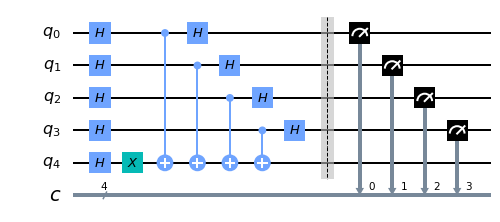

In [2]:
circ = QuantumCircuit(5,4)
circ.h(range(5))
circ.x(4)
circ.cx(range(4), 4)
circ.h(range(4))
circ.barrier()
circ.measure(range(4), range(4))

print('gates: ', circ.count_ops())
print('depth: ', circ.depth())
circ.draw('mpl', scale=0.5)

The above is the circuit *we* think. However, if one assign this to a real machine, the quantum computer thinks in a different way.

### What the device really does

To know what the real quantum computer thinks, we need to first select a device.
Here we choose a machine that is *least busy*.
You are encouraged to try different backend, and see if there is any difference between the transpiled circuits.

You are encouraged to try different basis gates and the optimization level.

backend:  ibmq_vigo
gates:  OrderedDict([('cx', 14), ('u2', 12), ('measure', 4), ('u3', 2), ('barrier', 1)])
depth:  17


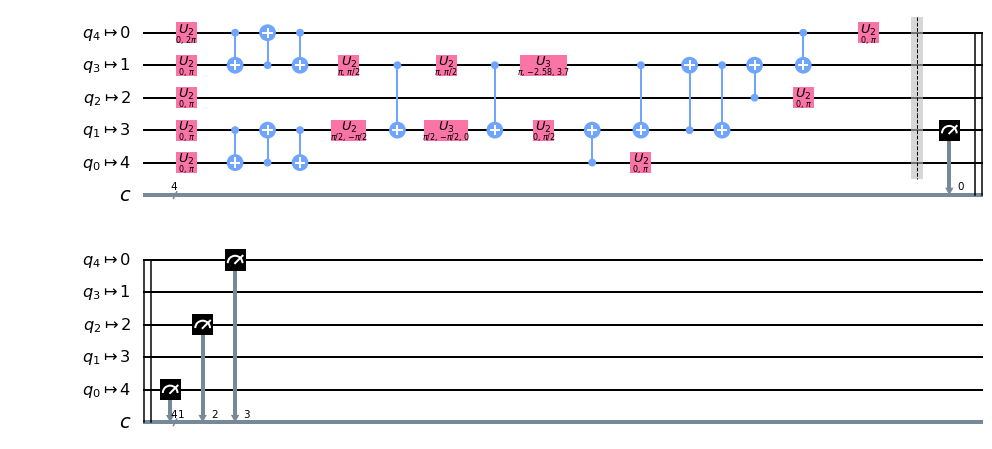

In [6]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and 
                                       not x.configuration().simulator and x.status().operational==True))
print('backend: ', backend)

from qiskit.compiler import transpile
trans_circ = transpile(circ, backend, basis_gates=None, optimization_level=3)
print('gates: ', trans_circ.count_ops())
print('depth: ', trans_circ.depth())
trans_circ.draw('mpl', scale=0.5)

**Note**

`basis_gates`:
You can select a list of basis gate names to unroll to (e.g: ['u1', 'u2', 'u3', 'cx']). 
- `None`: do not unroll


`optimization_level`:
How much optimization to perform on the circuits. Higher levels generate more optimized circuits, at the expense of longer transpilation time. 
- `0`: no optimization, just maps the circuit to the backend 
- `1`: light optimization (collapsing adjacent gates)
- `2`: heavy optimization (noise-adaptive, gate cancellation due to gate commutation relations)
- `3`: even heavier optimization (resynthesis)
- `None`: default level is set to be `1`

From this example, we can easily see the *words* we say is defferent from the way the quantum computer *receive*. 

***Question 1*: What causes the differences?**

***Question 2:*** 
**Are the two circuits equivalent?** 

# Example: GHZ States

A standard GHZ state is a entangled state that consists of at least three subsystems (particle states). Suppose each subsystem has dimension $D$, and the number of the subsystem is $N$ where $N>2$, the GHZ state is an entangled quantum state such that
$$ 
\left| \text{GHZ} \right> 
= \dfrac{1}{\sqrt{D}} 
\displaystyle\sum_{n=1}^N 
\displaystyle\sum_{d=0}^{D-1} 
\left|d\right>^{\otimes n}. 
$$
Here, we only consider the cases with $d=\{0,1\}$ since all elements is now being assumed as two-level systems. If the system contains three qubits ($N=3$), the corresponding GHZ state reads
$$
\begin{align*}
\left| \text{GHZ} \right> 
&= 
\dfrac{1}{\sqrt{2}} 
\displaystyle\sum_{n=1}^3 
\displaystyle\sum_{d=0}^{1} 
\left|d\right>^{\otimes n} \\
&=
\dfrac{1}{\sqrt{2}} 
\left(
\left|0\right> \otimes \left|0\right> \otimes \left|0\right> 
+ 
\left|1\right> \otimes \left|1\right> \otimes \left|1\right>
\right) \\
&=
\left(
\left|000\right>
+ 
\left|111\right>
\right).
\end{align*}
$$

## Standard quantum circuit for 3-qubit GHZ state

The quantum circuit to generate a 3-qubit GHZ state can be build by the below codes with Qiskit. The output is what we think the circuit should look like.

quantum circuit for 3-qubit GHZ state:


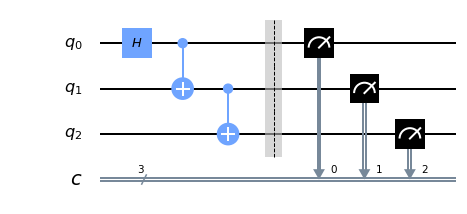

In [2]:
import numpy as np

n = 3
# create a quantum circuit with both quantum (the first argument) and classical (the second argument) registers
GHZ_circuit = QuantumCircuit(n, n)
# append a Hadamard gate to q0
GHZ_circuit.h(0)
# append CNOT gate which the first argument is the controlled qubit while the second is the target
for i in range(0, n-1):
    GHZ_circuit.cx(i, i+1)
GHZ_circuit.barrier() # no net effect here, just devide the operations and the measurements
# do measurements of the qubit (1st argument) with classical bits (2nd argument)
GHZ_circuit.measure(range(n), range(n))

# draw the quantum circuit
print(f'quantum circuit for {n}-qubit GHZ state:')
GHZ_circuit.draw(output='mpl')

However, thanks to the physical layout of the quantum computer, the real device will actually run a restructured quantum circuit that perform the same task but being compatible with a particular quantum computer. 
The `initial_layout` parameter indicates the initial position of virtual qubits on physical qubits. It makes the circuit compatible with `coupling_map` constraints if possible. The output layout is not quaranteed to be the same.
An example is given as below:
```python
layout = [0, 3, 5]  # virtual qubits are ordered (in addition to named)
```
or
```python
layout = {qr[0]: 0,
 qr[1]: 3,
 qr[2]: 5}
```
and use the commmand as `transpiled_circuit = transpile(circuit, backend, basis_gates, initial_layout=layout, optimization_level=None)`.
To view the circuit under the transpilation, we run the below cell.

chosen backend:  ibmq_16_melbourne
quantum circuit after transpile:


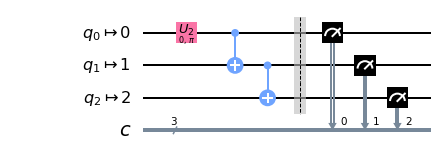

In [5]:
# choose a backend that is least busy
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                       not x.configuration().simulator and x.status().operational==True))
# transpile your circuit
from qiskit.compiler import transpile
from qiskit.transpiler import CouplingMap, Layout
# specify the layout and coupling map
layout = [0, 1, 2]
coupling = [[0,1], [1,2]]
# transpile
trans_GHZ_circuit = transpile(GHZ_circuit, backend, initial_layout=layout, coupling_map=coupling, optimization_level=3)

print('chosen backend: ', backend)
print('quantum circuit after transpile:')
trans_GHZ_circuit.draw(output='mpl', scale=0.5)

The choice of `coupling_map` may affect the transpiled layout. It is a parameter that determein the coupling map to target in mapping, perhaps custom. The priority od `coupling_map` is higher than `initial_layout`. This can be checked by specifying contradictory coupling map and layout. The coneection relations of each device can be found on [IBM Quantum Experience](https://quantum-computing.ibm.com/).
Instance of `coupling_map`: `[[0,1], [3,5]]` specifies the two-qubit interactions between `q0`-`q1`, `q3`-`q5`.

We can see that the Hadamard gate in the circuit is now changed by a $U_2$ gate with angles $0$ and $\pi$. You can check the corresponding matrix from and show that the two do the same operation. The further information about $U_2$ gate can be found at [IBM Instruction glossary](https://quantum-computing.ibm.com/docs/circ-comp/q-gates#u2-gate). After a series of runnings, you may find out that all trail share the same circuit. The reason for this is because we consider only the simplest case $N=3$ here. 

### Execute the experiment

In this part, we compare the performance of the simulator ```qasm_simulator``` (no noise, providing an ideal outcome) with a real quantum computer (noise exists). We assign the job and get the counts of different states. The measurement outcome will be a probability distribution through all possibilities.

### 1. Simulator

{'000': 518, '111': 506}


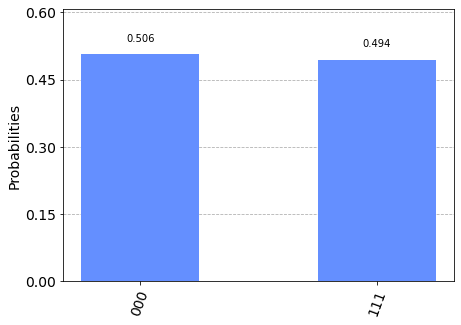

In [35]:
from qiskit.visualization import plot_histogram
# execute the circuit
shots = 1024
backend = Aer.get_backend('qasm_simulator')
result = execute(GHZ_circuit, backend, shots=shots).result()
counts = result.get_counts(GHZ_circuit)
# print out results
print(counts)
plot_histogram(counts)

### 2. Real device

Compare to the results by the simulator, we are no doing the job on a real device. To reduce the quene time, we choose a backend that is least busy (rather than the one we transpile the quantum circuit in the first part).

backend:  ibmq_vigo
{'111': 394, '000': 499, '101': 4, '001': 14, '011': 31, '110': 68, '010': 10, '100': 4}


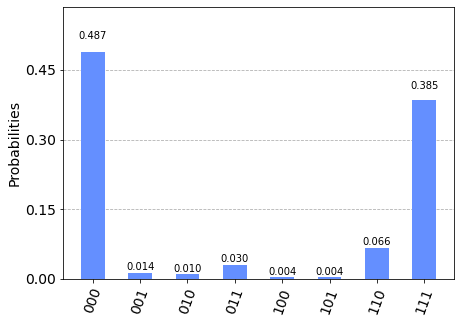

In [37]:
# execute the circuit
shots = 1024
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 and 
                                       not x.configuration().simulator and x.status().operational==True))
print('backend: ', backend)
result = execute(GHZ_circuit, backend, shots=shots, optimization_level=3).result()
counts = result.get_counts(GHZ_circuit)
# print out results
print(counts)
plot_histogram(counts)

As we can see from the histogram, some counts on the *impossible states* pop up. These errors come from the dissipations and the noise of a real quantum computer, and may affect the outcome result if the *fluctuation* is too large. One of the possible solution is to increase the shots of your experiment, or you can just assign the job to the device that can provide a higher-fidelity performance.

In [6]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

# Exercise

**Please construct a circuit of 5-qubit GHZ state and view the physical layout on a real quantum computer. Do the measurements and compare the results in different layouts. What cause the differences?**